# Problem Statement

##### Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

##### As a Sata scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes.

- Additional Views
    - This is the classification problem for churning, we need to track the various metrics like Recall, ROC-AUC curve etc.
    - As this industry is very competitive we need to focus more on the trained feature importances.

# Installing Packages

In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

import time

In [411]:
data = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv")

data.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


- Removing the unwanted column Unnamed: 0

In [412]:
data.drop("Unnamed: 0", axis = 1, inplace = True)

In [413]:
data.head()

,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [414]:
data.shape

(19104, 13)

In [415]:
data.nunique()

MMM-YY                     24
Driver_ID                2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Income                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

In [416]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


# Converting features to respective data-types

In [417]:
data["MMM-YY"] = pd.to_datetime(data["MMM-YY"])
data["Dateofjoining"] = pd.to_datetime(data["Dateofjoining"])
data["LastWorkingDate"] = pd.to_datetime(data["LastWorkingDate"])

In [418]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

# Check for missing values and Prepare data for KNN Imputation

In [419]:
data.isnull().sum() / len(data) * 100

MMM-YY                   0.000000
Driver_ID                0.000000
Age                      0.319305
Gender                   0.272194
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
LastWorkingDate         91.541039
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

- There are missing values found in `AGE`, `Gender`
- `LastWorkingDate` feature contains missing values which indicates the driver has not left the company yet.

In [420]:
num_vars = data.select_dtypes(np.number)

num_vars.columns

Index(['Driver_ID', 'Age', 'Gender', 'Education_Level', 'Income',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [421]:
num_vars.drop(["Driver_ID"], axis = 1, inplace = True)

# KNN Imputation

In [422]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(num_vars)
data_new = imputer.transform(num_vars)

In [423]:
data_new = pd.DataFrame(data_new)

In [424]:
data_new.columns = num_vars.columns

In [425]:
data_new.isnull().sum()

Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
dtype: int64

- We have successfully imputed the missing values using KNNImputer

In [426]:
data_new.nunique()

Age                        70
Gender                      6
Education_Level             3
Income                   2383
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

# Concatenating dataframes

In [427]:
resultant_columns = list(set(data.columns).difference(set(num_vars)))

resultant_columns

['MMM-YY', 'LastWorkingDate', 'Dateofjoining', 'City', 'Driver_ID']

In [428]:
new_df = pd.concat([data_new, data[resultant_columns]], axis=1)

new_df.shape

(19104, 13)

In [429]:
new_df.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,MMM-YY,LastWorkingDate,Dateofjoining,City,Driver_ID
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,2019-01-01,NaT,2018-12-24,C23,1
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,2019-02-01,NaT,2018-12-24,C23,1
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2019-03-01,2019-03-11,2018-12-24,C23,1
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020-11-01,NaT,2020-11-06,C7,2
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020-12-01,NaT,2020-11-06,C7,2


# Data Preprocessing
# Feature Engineering

In [430]:
agg_functions = {
    "Age": "max",
    "Gender": "first",
    "Education_Level": "last",
    "Income": "last",
    "Joining Designation": "last",
    "Grade": "last",
    "Total Business Value": "sum",
    "Quarterly Rating": "last",
    "LastWorkingDate": "last",
    "City": "first",
    "Dateofjoining": "last"
}

processed_df = new_df.groupby(["Driver_ID", "MMM-YY"]).aggregate(agg_functions).sort_index(ascending = [True, True])

processed_df.head()

Age  Gender  Education_Level   Income  \
Driver_ID MMM-YY                                               
1         2019-01-01  28.0     0.0              2.0  57387.0   
          2019-02-01  28.0     0.0              2.0  57387.0   
          2019-03-01  28.0     0.0              2.0  57387.0   
2         2020-11-01  31.0     0.0              2.0  67016.0   
          2020-12-01  31.0     0.0              2.0  67016.0   

                      Joining Designation  Grade  Total Business Value  \
Driver_ID MMM-YY                                                         
1         2019-01-01                  1.0    1.0             2381060.0   
          2019-02-01                  1.0    1.0             -665480.0   
          2019-03-01                  1.0    1.0                   0.0   
2         2020-11-01                  2.0    2.0                   0.0   
          2020-12-01                  2.0    2.0                   0.0   

                      Quarterly Rating LastWorkingDate City Dateofjoining  
Driver_ID MMM-YY                                                           
1         2019-01-01               2.0             NaT  C23    2018-12-24  
          2019-02-01               2.0             NaT  C23    2018-12-24  
          2019-03-01               2.0      2019-03-11  C23    2018-12-24  
2         2020-11-01               1.0             NaT   C7    2020-11-06  
          2020-12-01               1.0             NaT   C7    2020-11-06

In [431]:
final_data = pd.DataFrame()

In [432]:
final_data["Driver_ID"] = new_df["Driver_ID"].unique()

In [433]:
final_data['Age'] = list(processed_df.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
final_data['Gender'] = list(processed_df.groupby('Driver_ID').agg({'Gender':'last'})['Gender'])
final_data['City'] = list(processed_df.groupby('Driver_ID').agg({'City':'last'})['City'])
final_data['Education'] = list(processed_df.groupby('Driver_ID').agg({'Education_Level':'last'})['Education_Level'])
final_data['Income'] = list(processed_df.groupby('Driver_ID').agg({'Income':'last'})['Income'])
final_data['Joining_Designation'] = list(processed_df.groupby('Driver_ID').agg({'Joining Designation':'last'})['Joining Designation'])
final_data['Grade'] = list(processed_df.groupby('Driver_ID').agg({'Grade':'last'})['Grade'])
final_data['Total_Business_Value'] = list(processed_df.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])
final_data['Last_Quarterly_Rating'] = list(processed_df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating'])

In [434]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0


In [435]:
final_data.shape

(2381, 10)

# Create a column which tells whether the quarterly rating has increased for that driver - for those whose quarterly rating has increased we assign the value 1

In [436]:
first_quarter = processed_df.groupby(["Driver_ID"]).agg({"Quarterly Rating": "first"})

last_quarter = processed_df.groupby(["Driver_ID"]).agg({"Quarterly Rating": "last"})

qr = (last_quarter["Quarterly Rating"] > first_quarter["Quarterly Rating"]).reset_index()

empid = qr[qr["Quarterly Rating"] == True]["Driver_ID"]

qrl = []
for i in final_data["Driver_ID"]:
    if i in empid.values:
        qrl.append(1)
    else:
        qrl.append(0)


final_data["Quarterly_Rating_Increased"] = qrl

In [437]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1


# Target variable creation: Create a column called target which tells whether the driver has left the company- driver whose last working day is present will have the value 1

In [438]:
lwd = (processed_df.groupby(["Driver_ID"]).agg({"LastWorkingDate": "last"})["LastWorkingDate"].isna()).reset_index()

lwrid = lwd[lwd["LastWorkingDate"] == True]["Driver_ID"]
target = []

for i in final_data["Driver_ID"]:
    if i in lwrid.values:
        target.append(0)
    else:
        target.append(1)
        
final_data["target"] = target

In [439]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,target
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,1
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0,1
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0,1
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1,0


# Create a column which tells whether the monthly income has increased for that driver - for those whose monthly income has increased we assign the value 1

In [440]:
mrf = processed_df.groupby(["Driver_ID"]).agg({"Income": "first"})

mrl = processed_df.groupby(["Driver_ID"]).agg({"Income": "last"})

mr = (mrl["Income"] > mrf["Income"]).reset_index()

empid = mr[mr["Income"] == True]["Driver_ID"]
income = []
for i in final_data["Driver_ID"]:
    if i in empid.values:
        income.append(1)
    else:
        income.append(0)
        
final_data["Salary_Increased"] = income

In [441]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,target,Salary_Increased
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,1,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0,1,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0,1,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1,0,0


In [442]:
final_data["Salary_Increased"].value_counts(normalize=True)

0    0.98194
1    0.01806
Name: Salary_Increased, dtype: float64

- Around 1.8% drivers income have been increased.

# Statistical Summary

In [443]:
final_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Age,2381.0,3.377018e+01,5.933265e+00,21.0,30.0,33.0,37.0,58.0
Gender,2381.0,4.105838e-01,4.914963e-01,0.0,0.0,0.0,1.0,1.0
Education,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Income,2381.0,5.933416e+04,2.838367e+04,10747.0,39104.0,55315.0,75986.0,188418.0
Joining_Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0
Grade,2381.0,2.096598e+00,9.415218e-01,1.0,1.0,2.0,3.0,5.0
Total_Business_Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Last_Quarterly_Rating,2381.0,1.427971e+00,8.098389e-01,1.0,1.0,1.0,2.0,4.0
Quarterly_Rating_Increased,2381.0,1.503570e-01,3.574961e-01,0.0,0.0,0.0,0.0,1.0


- There are total of 2831 different drivers data.
- Age of drivers range from 21years to 58years.
- 75% drivers monthly income is <= 75986.
- 75% drivers acquired 4173650 as total business values.

In [444]:
final_data.describe(include = 'object')

,City
count,2381
unique,29
top,C20
freq,152


- Majority of drivers are coming from C20 city

In [445]:
final_data["Gender"].value_counts()

0.0    1400
1.0     975
0.6       3
0.2       2
0.4       1
Name: Gender, dtype: int64

- Mojority of drivers are male

In [446]:
final_data["Education"].value_counts()

2.0    802
1.0    795
0.0    784
Name: Education, dtype: int64

- Majority of drivers have completed their graduation.

In [447]:
final_data["target"].value_counts()

1    1616
0     765
Name: target, dtype: int64

- Out of 2381 drivers 1616 have left the company.

In [448]:
n = ['Gender','Education','Joining_Designation','Grade','Last_Quarterly_Rating','Quarterly_Rating_Increased']

for i in n:
    print("------------------------------------------------------------")
    print(final_data[i].value_counts(normalize=True) * 100)

------------------------------------------------------------
0.0    58.798824
1.0    40.949181
0.6     0.125997
0.2     0.083998
0.4     0.041999
Name: Gender, dtype: float64
------------------------------------------------------------
2.0    33.683326
1.0    33.389332
0.0    32.927341
Name: Education, dtype: float64
------------------------------------------------------------
1.0    43.091138
2.0    34.229315
3.0    20.705586
4.0     1.511970
5.0     0.461991
Name: Joining_Designation, dtype: float64
------------------------------------------------------------
2.0    35.909282
1.0    31.121378
3.0    26.165477
4.0     5.795884
5.0     1.007980
Name: Grade, dtype: float64
------------------------------------------------------------
1.0    73.246535
2.0    15.203696
3.0     7.055859
4.0     4.493910
Name: Last_Quarterly_Rating, dtype: float64
------------------------------------------------------------
0    84.964301
1    15.035699
Name: Quarterly_Rating_Increased, dtype: float64


- 58% of drivers are male while female constitutes around 40%
- 33% of drivers have completed graduation and 12+ education
- 43% of drivers have 1 as joining_designation
- Around 36% of drivers graded as 2
- Around 73% of drivers rated as 1 on last quarter
- Only 15% of drivers rating has been increased on quarterly

# Univariate Analysis

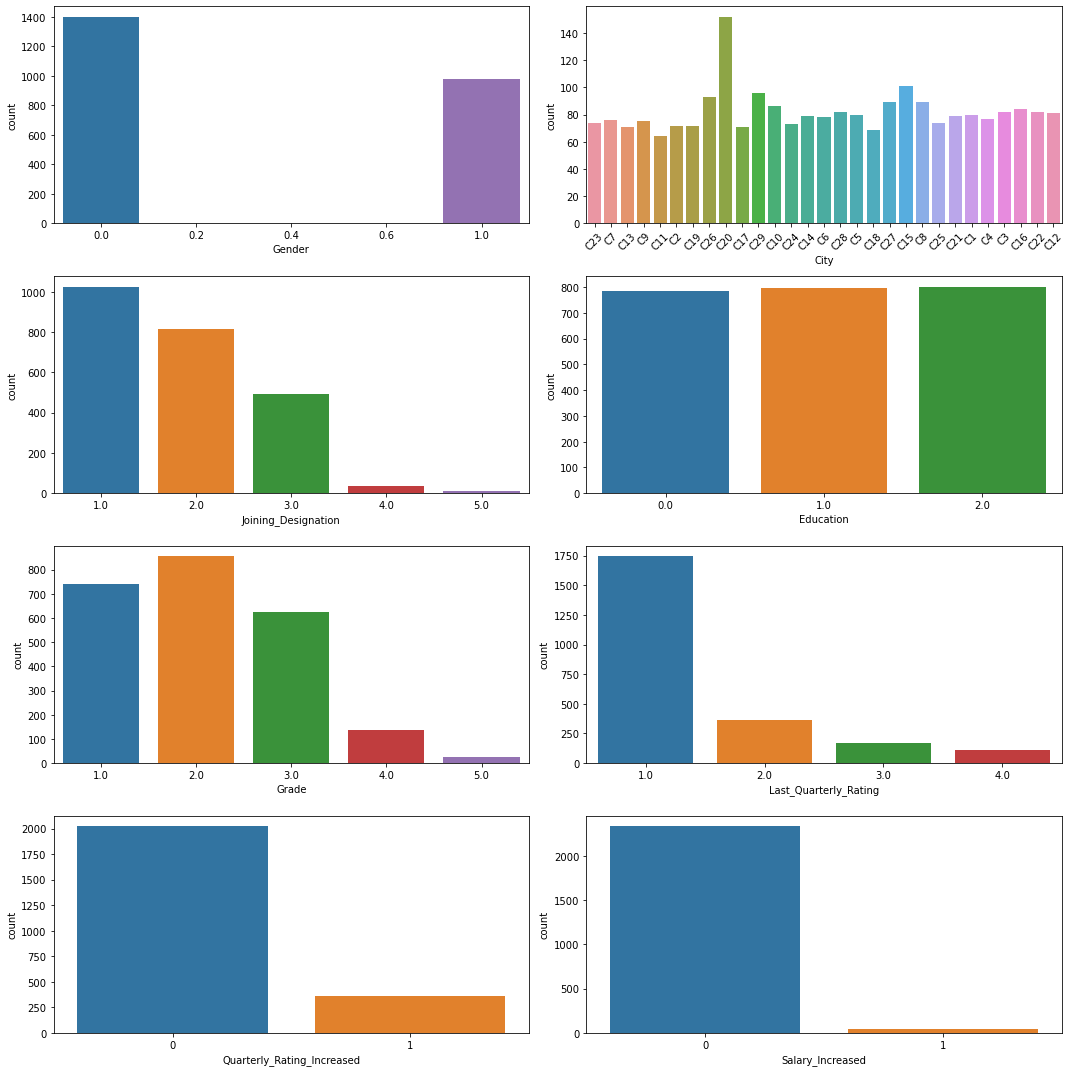

In [449]:
plt.figure(figsize=(15, 15))
plt.subplot(421)
sns.countplot(data=final_data, x="Gender")
# final_data["Gender"].value_counts(normalize=True).plot.bar('Gender')

plt.subplot(422)
sns.countplot(data=final_data, x="City")
plt.xticks(rotation="45")

plt.subplot(423)
sns.countplot(data=final_data, x="Joining_Designation")

plt.subplot(424)
sns.countplot(data=final_data, x="Education")

plt.subplot(425)
sns.countplot(data=final_data, x="Grade")

plt.subplot(426)
sns.countplot(data=final_data, x="Last_Quarterly_Rating")

plt.subplot(427)
sns.countplot(data=final_data, x="Quarterly_Rating_Increased")

plt.subplot(428)
sns.countplot(data=final_data, x="Salary_Increased")

plt.tight_layout()

**Insights**

- Out of 2381 employees, 1404 employees are of the Male gender and 977 are females.
- Out of 2381 employees, 152 employees are from city C20 and 101 from city C15.
- Out of 2381 employees, 802 employees have their education as Graduate and 795 have completed their 12.
- Out of 2381 employees, 1026 joined with the grade as 1, 815 employees joined with the grade 2.
- Out of 2381 employees, 855 employees had their designation as 2 at the time of reporting.
- Out of 2381 employees, 1744 employees had their last quarterly rating as 1.
- Out of 2381 employees, the quarterly rating has not increased for 2076 employees.

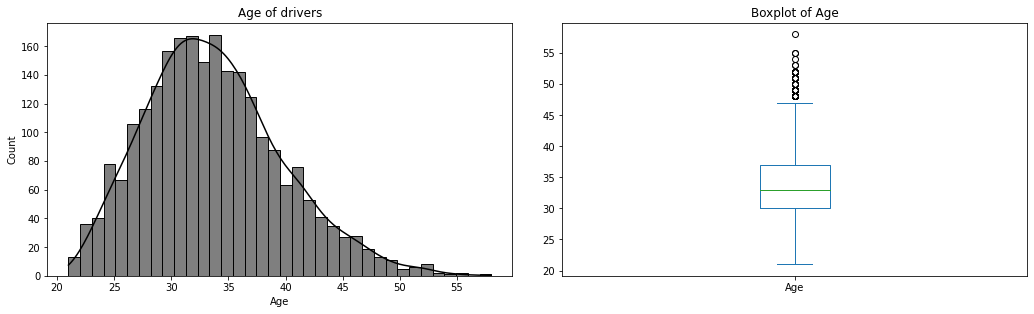

In [450]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.histplot(final_data['Age'],color='black', kde=True)
plt.title("Age of drivers")
plt.subplot(122)
final_data['Age'].plot.box(title='Boxplot of Age')
plt.tight_layout(pad=3)

**Insights**

- The distribution of age slightly skewed on right which might indicate the outliers in the data

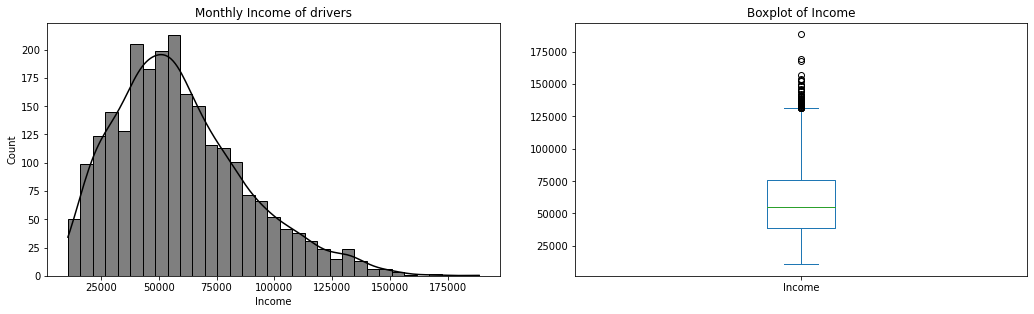

In [451]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.histplot(final_data['Income'],color='black', kde=True)
plt.title("Monthly Income of drivers")
plt.subplot(122)
final_data['Income'].plot.box(title='Boxplot of Income')
plt.tight_layout(pad=3)

**Insights**

- The distribution of monthly income skewed on right which might indicate the outliers in the data

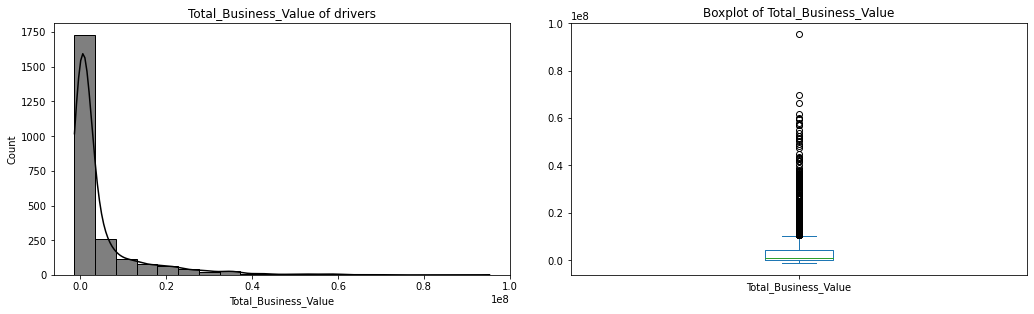

In [452]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.histplot(final_data['Total_Business_Value'],color='black', kde=True, bins=20)
plt.title("Total_Business_Value of drivers")
plt.subplot(122)
final_data['Total_Business_Value'].plot.box(title='Boxplot of Total_Business_Value')
plt.tight_layout(pad=3)

**Insights**

- The distribution of total business value highly skewed on right which might indicate the outliers in the data

# Bi-Variate Analysis

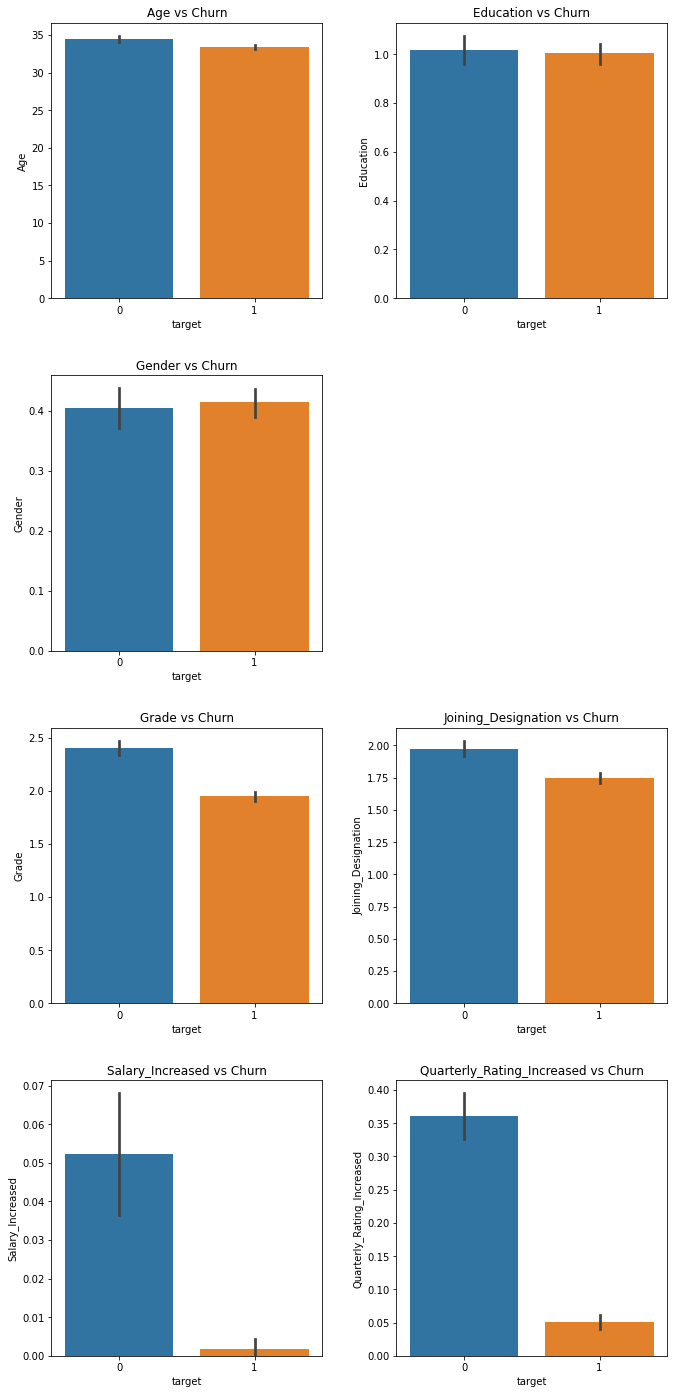

In [453]:
plt.figure(figsize=(10,20))

plt.subplot(421)
sns.barplot(data=final_data, x="target", y="Age")
plt.title("Age vs Churn")

plt.subplot(422)
sns.barplot(data=final_data, x="target", y="Education")
plt.title("Education vs Churn")

plt.subplot(423)
sns.barplot(data=final_data, x="target", y="Gender")
plt.title("Gender vs Churn")

plt.subplot(425)
sns.barplot(data=final_data, x="target", y="Grade")
plt.title("Grade vs Churn")

plt.subplot(426)
sns.barplot(data=final_data, x="target", y="Joining_Designation")
plt.title("Joining_Designation vs Churn")

plt.subplot(427)
sns.barplot(data=final_data, x="target", y="Salary_Increased")
plt.title("Salary_Increased vs Churn")

plt.subplot(428)
sns.barplot(data=final_data, x="target", y="Quarterly_Rating_Increased")
plt.title("Quarterly_Rating_Increased vs Churn")

plt.tight_layout(pad=3)

**Insights**

- The proportion of Age, gender and education is more or less the same for both the employees who left the organization and those who did not leave.
- The employees who have their grade as 3 or 4 at the time of joining are less likely to leave the organization.
- The employees whose quarterly rating has increased are less likely to leave the organization.
- The employees whose monthly salary has not increased are more likely to leave the organization.

# Correlation Analysis

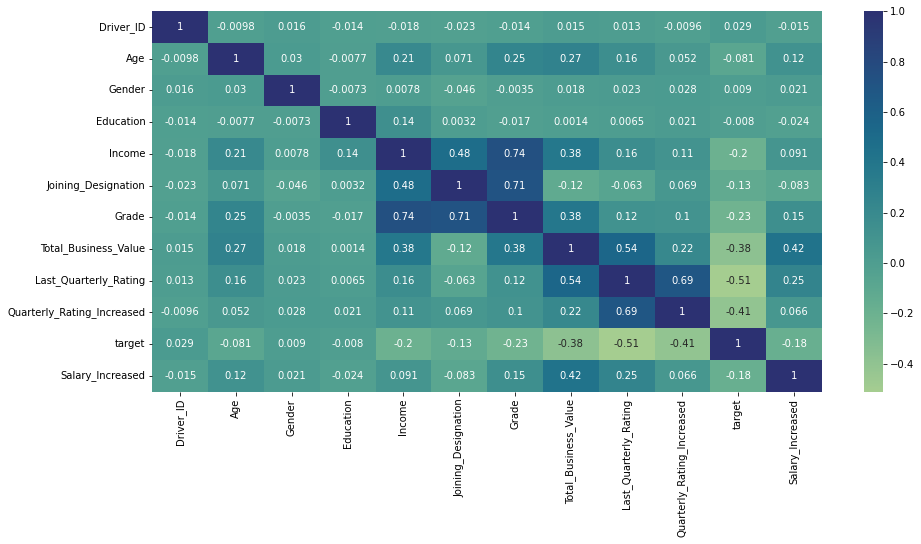

In [454]:
plt.figure(figsize=(15, 7))

sns.heatmap(final_data.corr(method="pearson"), annot=True, cmap="crest")
plt.show()

**Insights**
- Income and Grade is highly correlated
- Joining Designation and Grade is highly correlated
- Total Business value and salary increament is correlated

# One-Hot Encoding

**As there is only one categorical values in our dataset. We will opt one hot encoder to convert it to numerical.**

In [455]:
final_data = pd.concat([final_data, final_data['City']], axis=1)

In [456]:
final_data.shape

(2381, 14)

# Standardization (for training data)

In [457]:
X = final_data.drop(["Driver_ID", "target", "City"], axis = 1)
X_cols = X.columns
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

In [458]:
X = pd.DataFrame(X)

X.columns = X_cols

X

,Age,Gender,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,Salary_Increased
0,0.189189,0.0,1.0,0.262508,0.00,0.00,0.032064,0.333333,0.0,0.0
1,0.270270,0.0,1.0,0.316703,0.25,0.25,0.014326,0.000000,0.0,0.0
2,0.594595,0.0,1.0,0.308750,0.25,0.25,0.017944,0.000000,0.0,0.0
3,0.216216,0.0,0.0,0.200489,0.00,0.00,0.015570,0.000000,0.0,0.0
4,0.270270,1.0,0.5,0.382623,0.50,0.50,0.027405,0.333333,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2376,0.351351,0.0,0.0,0.405626,0.25,0.50,0.239197,1.000000,1.0,0.0
2377,0.351351,1.0,0.0,0.007643,0.00,0.00,0.014326,0.000000,0.0,0.0
2378,0.648649,0.0,0.0,0.138588,0.25,0.25,0.043432,0.000000,0.0,0.0
2379,0.189189,1.0,1.0,0.330673,0.00,0.00,0.024436,0.000000,0.0,0.0


# Train & Test Split

In [459]:
y = final_data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=True)

In [460]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (1904, 10)
X_test Shape:  (477, 10)
y_train Shape:  (1904,)
y_test Shape:  (477,)


# Random Forest Classifier - Before Balancing

**Keeping max_depth small to avoid overfitting**

In [461]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 100}
Best Score:  0.862861633218953

Elapsed Time:  5.860330104827881


              precision    recall  f1-score   support

           0       0.72      0.57      0.64       148
           1       0.82      0.90      0.86       329

    accuracy                           0.80       477
   macro avg       0.77      0.74      0.75       477
weighted avg       0.79      0.80      0.79       477



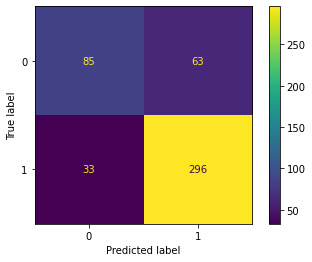

In [462]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

**Random Forest Classifier with balanced class weight**
- Out of all prediction, the measure for correctly predicted 0 is 73% and for 1 is 82% (Precision)
- Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 90% (Recall)

**As this is imbalanced dataset. We give importance to F1-Score metrics**
- F1 Score of 0 is 64%
- F! Score of 1 is 86%

**Lets try out bootstrapped random forest using subsample**

In [463]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 200}
Best Score:  0.8611423652105162

Elapsed Time:  2.3675687313079834


              precision    recall  f1-score   support

           0       0.71      0.57      0.64       148
           1       0.82      0.90      0.86       329

    accuracy                           0.80       477
   macro avg       0.77      0.74      0.75       477
weighted avg       0.79      0.80      0.79       477



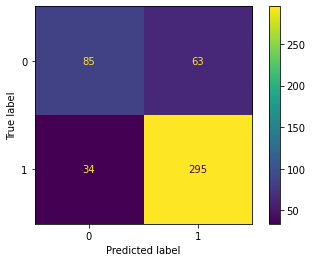

In [464]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

**Random Forest Classifier with balanced class weight**
- Out of all prediction, the measure for correctly predicted 0 is 75% and for 1 is 83% (Precision)
- Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 91% (Recall)

**As this is imbalanced dataset. We give importance to F1-Score metrics**
- F1 Score of 0 is 65%
- F! Score of 1 is 87%

**There is not much significant difference in the matrices observed for bootstrapped Random Forest and Weighted Random Forest**

**Lets try balancing**

# Balancing Dataset using SMOTE

**As the target variable is imbalanced towards 1. We will use SMOTE to balance the dataset**

In [465]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 7)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 1287
Before OverSampling, counts of label '0': 617 

After OverSampling, the shape of train_X: (2574, 10)
After OverSampling, the shape of train_y: (2574,) 

After OverSampling, counts of label '1': 1287
After OverSampling, counts of label '0': 1287


# Ensemble Learning: Bagging

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 100}
Best Score:  0.7834986325743847

Elapsed Time:  2.393531084060669
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       148
           1       0.83      0.91      0.87       329

    accuracy                           0.81       477
   macro avg       0.79      0.74      0.76       477
weighted avg       0.80      0.81      0.80       477



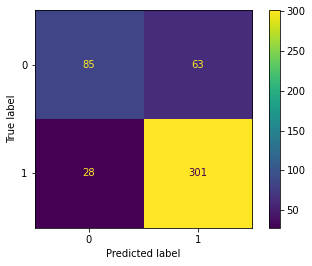

In [466]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

**Random Forest Classifier with balanced class weight**
- Out of all prediction, the measure for correctly predicted 0 is 74% and for 1 is 83% (Precision)
- Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 91% (Recall)

**As this is imbalanced dataset. We give importance to F1-Score metrics**
- F1 Score of 0 is 65%
- F! Score of 1 is 87%

# ROC-AUC Curve

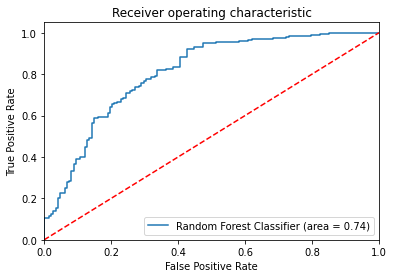

In [467]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Ensemble Learning: Boosting

# Gradient Boosting Classifier

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Params:  {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 150, 'subsample': 1}
Best Score:  0.8127428127428127

 Elapsed Time:  42.14409065246582
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       148
           1       0.82      0.83      0.82       329

    accuracy                           0.76       477
   macro avg       0.72      0.71      0.71       477
weighted avg       0.76      0.76      0.76       477



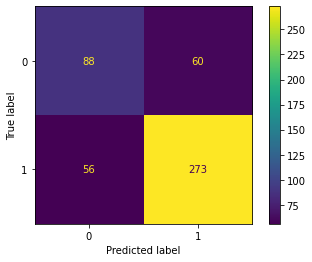

In [468]:
params = {
    "max_depth": [2, 3, 4],
    "loss": ["log_loss", "exponential"],
    "subsample": [0.1, 0.2, 0.5, 0.8, 1],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [50,100,150,200]
}

gbdt = GradientBoostingClassifier()
start_time = time.time()
c = GridSearchCV(estimator=gbdt, cv=3, n_jobs=-1, verbose=True, param_grid=params)

c.fit(X_train, y_train)
print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)

elapsed_time = time.time() - start_time
print("\n Elapsed Time: ", elapsed_time)

y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

**Gradient Boosting Classifier Metrics**
- Out of all prediction, the measure for correctly predicted 0 is 62% and for 1 is 82% (Precision)
- Out of all actual 0, the measure for correctly predicted is 60% and for 1 is 83% (Recall)

**As this is imbalanced dataset. We give importance to F1-Score metrics**
- F1 Score of 0 is 61%
- F1 Score of 1 is 83%

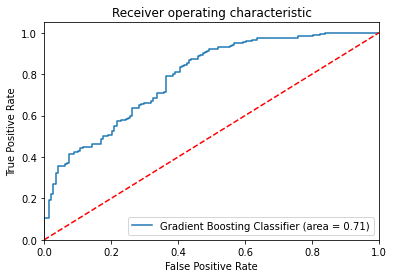

In [469]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Gradient Boosting Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# XGBoost Classifier

[19:20:38] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

XGBoost Classifier Score:  0.7589098532494759

               precision    recall  f1-score   support

           0       0.62      0.57      0.60       148
           1       0.81      0.84      0.83       329

    accuracy                           0.76       477
   macro avg       0.72      0.71      0.71       477
weighted avg       0.75      0.76      0.76       477



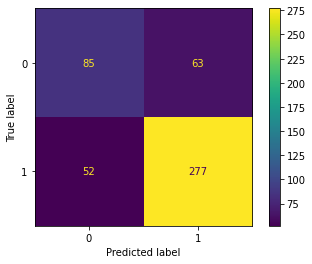

In [470]:
model = xgb.XGBClassifier(class_weight = "balanced")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("XGBoost Classifier Score: ", model.score(X_test, y_test))
print("\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

**XGBoost Classifier with balanced class weight**
- Out of all prediction, the measure for correctly predicted 0 is 62% and for 1 is 81% (Precision)
- Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 84% (Recall)

**As this is imbalanced dataset. We give importance to F1-Score metrics**
- F1 Score of 0 is 60%
- F1 Score of 1 is 83%

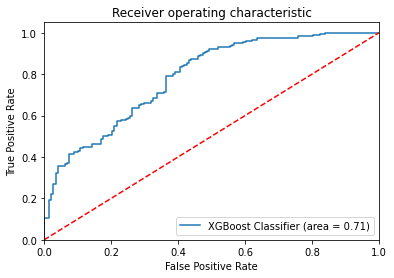

In [471]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Final Result Evaluation

- We observe that we are not getting very high recall on target 0 which may be due to small unbalanced dataset.
- Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also returned).


- **We observe that Random Forest with SMOTE outperforms rest of the models and has higher recall and precision values.**
    - The Random Forest method out of all predicted 0 the measure of correctly predicted is 73%, and for 1 it is 82%(Precision).
    - The Random Forest method out of all actual 0 the measure of correctly predicted is 56%, and for 1 it is 91%(Recall).
    - The ROC-AUC curve area for Random Forest Classifier is 0.74


- **Gradient Boosting Classifier Result**
    - Out of all prediction, the measure for correctly predicted 0 is 62% and for 1 is 82% (Precision)
    - Out of all actual 0, the measure for correctly predicted is 60% and for 1 is 83% (Recall)
    - The ROC-AUC curve area for Gradient Boosting Decision Tree Classifier is 0.71


- **XGBoost Classifier Result**
    - Out of all prediction, the measure for correctly predicted 0 is 62% and for 1 is 81% (Precision)
    - Out of all actual 0, the measure for correctly predicted is 57% and for 1 is 84% (Recall)
    - The ROC-AUC curve area for XGBoost Classifier is 0.71

# Feature Importance of the best model so far.

**Random Forest Classifier outperforms the rest of the modal.**

**Best parameters**

Best Params:  {'max_depth': 4, 'n_estimators': 50}

In [472]:
rf = RandomForestClassifier(max_depth = 4, n_estimators= 50, class_weight="balanced")

rf.fit(X_train, y_train)
print("Score of RandomForestClassifier: ", rf.score(X_test, y_test))


Score of RandomForestClassifier:  0.8113207547169812


In [473]:
importances = rf.feature_importances_
importances

array([0.03102136, 0.00163529, 0.00224746, 0.06775201, 0.05405412,
       0.0564535 , 0.22329128, 0.40343337, 0.1519475 , 0.0081641 ])

In [474]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

<Figure size 1080x504 with 0 Axes>

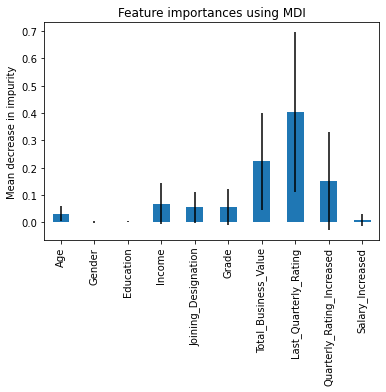

In [475]:
feature_importances = pd.Series(importances, X_train.columns)

plt.figure(figsize=(15,7))
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

plt.show()

**Insights**
- Last_Quarterly_Rating, Total_Business_Value & Quarterly_Rating_Increased are the most important features.

# Actionable Insights and Recommendation

- Out of 2381 drivers 1616 have left the company.
- We need to incentivise the drivers overtime or other perks to overcome churning
- The employees whose quarterly rating has increased are less likely to leave the organization.
- Company needs to implement the reward system for the customer who provide the feedback and rate drivers
- The employees whose monthly salary has not increased are more likely to leave the organization.
- Company needs to get in touch with those drivers whose monthly salary has not increased and help them out to earn more by provider bonus and perks.
- Out of 2381 employees, 1744 employees had their last quarterly rating as 1.
- Out of 2381 employees, the quarterly rating has not increased for 2076 employees. This is red flag for the company which needs to regulate.
- Company needs to look why customers are not rating drivers.
- Last_Quarterly_Rating, Total_Business_Value & Quarterly_Rating_Increased are the most important features. Company needs to tracks these features as predicators
- We observe that we are not getting very high recall on target 0 which may be due to small unbalanced dataset. More data will overcome this issue.
- The Random Forest Classifier attains the Recall score of 91% for the driver who left the company. Which indicates that model is performing the decent job.